In [1]:
%pylab inline
import gc
import numpy as np
import fitsio
import astropy.io.fits as pyfits
import numpy.lib.recfunctions as rfn
import astropy.table as astTable

import fpfs
from fpfs import fpfsBase

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [3]:
pltDir='plot/smallcat/'
if not os.path.isdir(pltDir):
    os.mkdir(pltDir)

In [77]:
gc.collect()
galDir      =   'small0_psf60'
ngrid       =   64
rcut        =   16
beg         =   ngrid//2-rcut
end         =   beg+2*rcut
beta        =   0.75
noiVar      =   1e-2
pixScale    =   0.168

In [78]:
# same for the noivar model
powIn       =   np.load('corPre/noiPows2.npy',allow_pickle=True).item()['%s'%rcut]*noiVar*100
powModel    =   np.zeros((1,powIn.shape[0],powIn.shape[1]))
powModel[0] =   powIn
# PSF
psfFname    =   os.path.join(galDir,'psf-60.fits')
psfData     =   pyfits.open(psfFname)[0].data
npad        =   (ngrid-psfData.shape[0])//2
psfData2    =   np.pad(psfData,(npad+1,npad),mode='constant')
assert psfData2.shape[0]==ngrid
psfData2    =   psfData2[beg:end,beg:end]
# FPFS Task
fpTask      =   fpfsBase.fpfsTask(psfData2,noiFit=powIn,beta=beta,debug=True)
fpTask0     =   fpfsBase.fpfsTask(psfData2,beta=beta,debug=True)

In [79]:
#img       =   psfData2*10
noiList   = []
imgList   = []
for im in range(1,2):
    imgAll   =   pyfits.getdata(os.path.join(galDir,'image-0-g1-0000.fits'))
    imgList.extend([imgAll[i*ngrid+beg:i*ngrid+end,j*ngrid+beg:j*ngrid+end] for i in range(100) for j in range(100)])
    noiAll   =   pyfits.getdata('noise/noi%04d.fits' %im)
    imgAll   =   noiAll*10*np.sqrt(noiVar)+imgAll
    noiList.extend([imgAll[i*ngrid+beg:i*ngrid+end,j*ngrid+beg:j*ngrid+end] for i in range(100) for j in range(100)])
    del noiAll,imgAll
    gc.collect()

In [80]:
gc.collect()

23

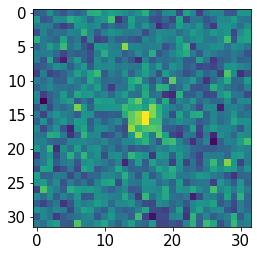

In [81]:
plt.imshow(noiList[2])

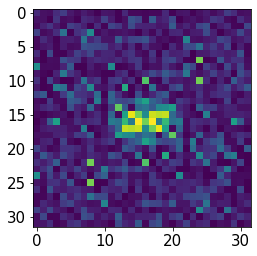

In [82]:
power=fpfs.imgutil.getFouPow(noiList[2])
plt.imshow(power)
pyfits.writeto('a.fits',power,overwrite=True)

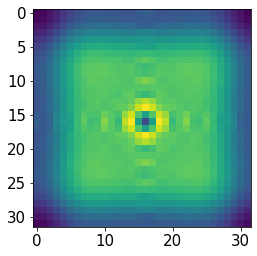

In [83]:
plt.imshow(powIn)

In [84]:
mm0=fpTask0.measure(imgList)
mm1=fpTask.measure(noiList)

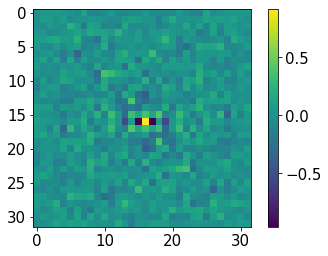

In [85]:
plt.imshow(fpTask.stackRes/1e4-fpTask0.stackRes/1e4)
plt.colorbar()

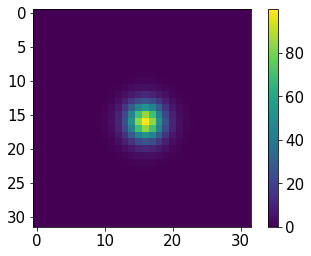

In [86]:
plt.imshow(fpTask0.stackRes/1e4)
plt.colorbar()

In [87]:
print(np.average((mm1['fpfs_M22c']-mm0['fpfs_M22c'])*(mm1['fpfs_M00']-mm0['fpfs_M00'])))
print(np.average((mm1['fpfs_M00']-mm0['fpfs_M00'])*(mm1['fpfs_M00']-mm0['fpfs_M00'])))

279.6723748868498
8436.185045211985


In [88]:
print(np.average(mm1['fpfs_M22c']-mm0['fpfs_M22c']))
print(np.average(mm1['fpfs_M00']-mm0['fpfs_M00']))
print(np.average(mm1['fpfs_M00']))

0.6877071418867039
-0.37012070884685255
529.1282696345122


In [89]:
print(np.average(mm1['fpfs_N00N22c']))
print(np.average(mm1['fpfs_N00N00']))

139.27290458610304
8595.67308234776


In [8]:
vdir='outSmall0-var7em3'
ngroup=16
igroup=0
C=2000.
noiRev=False
g1p=0.;g1m=0.
downp=0.;downm=0.
for ifield in range(1000):
    fname1=os.path.join(vdir,'psf60/fpfs-cut16-%04d-g1-2222.fits' %(ifield))
    moments1=pyfits.getdata(fname1)
    elli1=fpfsBase.fpfsM2E(moments1,C,rev=noiRev)
    g1p+=np.sum(elli1['fpfs_e1'])
    downp+=np.sum(elli1['fpfs_RE'])

    fname2=os.path.join(vdir,'psf60/fpfs-cut16-%04d-g1-0000.fits' %(ifield))
    moments2=pyfits.getdata(fname2)
    elli2=fpfsBase.fpfsM2E(moments2,C,rev=noiRev)
    g1m+=np.sum(elli2['fpfs_e1'])
    downm+=np.sum(elli2['fpfs_RE'])
    del elli1,elli2,moments1,moments2
    gc.collect()
print((g1p-g1m)/(downm+downp)*2./0.04-1)
print((g1p+g1m)/(downm+downp))

-0.08234059337404942
4.033060196408718e-05


In [90]:
vdir='outSmall0-var7em3'
igroup=0
C=1000.
noiRev=True
g1p=0.;g1m=0.
downp=0.;downm=0.
for ifield in range(2000):
    fname1=os.path.join(vdir,'psf60/fpfs-cut16-%04d-g1-2222.fits' %(ifield))
    moments1=pyfits.getdata(fname1)
    elli1=fpfsBase.fpfsM2E(moments1,C,rev=noiRev)
    g1p+=np.sum(elli1['fpfs_e1'])
    downp+=np.sum(elli1['fpfs_RE'])

    fname2=os.path.join(vdir,'psf60/fpfs-cut16-%04d-g1-0000.fits' %(ifield))
    moments2=pyfits.getdata(fname2)
    elli2=fpfsBase.fpfsM2E(moments2,C,rev=noiRev)
    g1m+=np.sum(elli2['fpfs_e1'])
    downm+=np.sum(elli2['fpfs_RE'])
    del elli1,elli2,moments1,moments2
    gc.collect()
print((g1p-g1m)/(downm+downp)*2./0.04-1)
print((g1p+g1m)/(downm+downp))
print(downm/1e7)
print(g1m/1e7)

-1.0484428639967387
0.010854391903197296
0.76128766123675
0.009000944283251969


In [18]:
vdir='outSmall0-var7em3'
ngroup=16
igroup=0
C=2000.
noiRev=False
del allStack
allStack=[]

for ifield in range(100):
    fname1=os.path.join(vdir,'psf60/fpfs-cut16-%04d-g1-2222.fits' %(ifield))
    moments1=pyfits.getdata(fname1)
    weight=moments1['fpfs_M00']+C
    ratio=  moments1['fpfs_N00N00']/weight**2.
    cc1=np.average(moments1['fpfs_N00N22c']/weight**2./(1+ratio))

    fname2=os.path.join(vdir,'psf60/fpfs-cut16-%04d-g1-0000.fits' %(ifield))
    moments2=pyfits.getdata(fname2)
    weight=moments2['fpfs_M00']+C
    ratio=  moments2['fpfs_N00N00']/weight**2.
    cc2=np.average(moments2['fpfs_N00N22c']/weight**2./(1+ratio))
    allStack.append((cc1+cc2)/2.)
    del moments1,moments2,ratio,weight,cc1,cc2
    gc.collect()

In [44]:
fname1=os.path.join(vdir,'psf60/fpfs-cut16-%04d-g1-2222.fits' %(ifield))
moments1=pyfits.getdata(fname1)
weight=moments1['fpfs_M00']+C
ratio=  moments1['fpfs_N00N00']/weight**2.
cc1=moments1['fpfs_N00N22c']/weight**2./(1+ratio)
ee1=moments1['fpfs_M22c']/weight

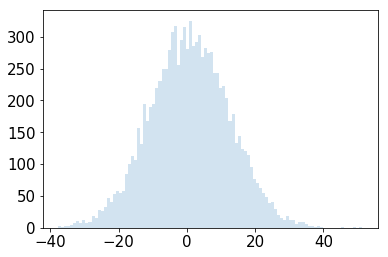

In [49]:
_=plt.hist(cc1*1e5,bins=100,alpha=0.2)

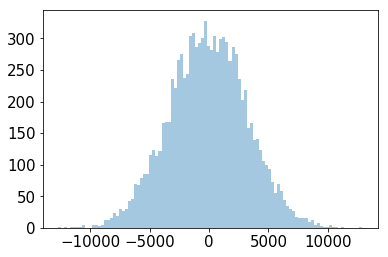

In [50]:
_=plt.hist(ee1*1e5,bins=100,alpha=0.4)


1.2673668635700298e-05


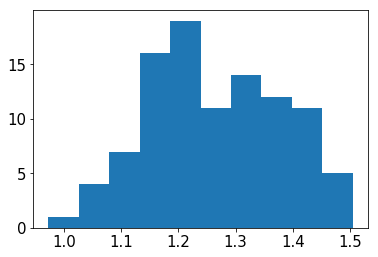

In [22]:
plt.hist(np.array(allStack)*1e5)
print(np.average(allStack))